In [56]:
from source import data_import
from source.constants import CHANNELS, FREQUENCY_RANGES, DEFAULT_PATIENTS

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyarrow as pa
from source import calculate_mean_psd

In [57]:
def import_patients_with_intervals(channels, patient_ids, seizure_flag, preseizure_intervals):
    # Initialize an empty list to store dataframes
    dfs = []

    # Iterate over preseizure_intervals
    for preseizure_interval in preseizure_intervals:
        # Use the custom data import function
        df = data_import.import_patients(
            channels=channels,
            patient_ids=patient_ids,
            seizure_flag=seizure_flag,
            preseizure_interval=preseizure_interval
        )

        # Filter for segments which are either seizure or before seizure
        df = df[~(df['is_seizure'] & df['before_seizure'])]

        # Create column to identify is_seizure, before_seizure (dependent on value of preseizure_interval), and neither/nor
        conditions = [
            (df['is_seizure'] == True),
            (df['before_seizure'] == True),
        ]
        values = ["is_seizure", "before_seizure"]

        df.loc[:,'categories'] = np.select(conditions, values, default="neither/nor")

        # Drop unnecessary columns
        df = df.drop(["is_seizure", "before_seizure"], axis=1)

        # Add a 'preseizure_interval' column to the dataframe
        df['preseizure_interval'] = preseizure_interval

        # Group by categories and preseizure interval
        df = df.groupby(["categories", "preseizure_interval"]).var().reset_index()

        # Melt it into right shape for plotting
        df = pd.melt(df, id_vars=["categories", "preseizure_interval"], var_name="sensors", value_name="variances")

        df = df

        # Append the dataframe to the list
        dfs.append(df)

    # Concatenate the list of dataframes into a single dataframe
    result_df = pd.concat(dfs, ignore_index=True)

    return result_df



In [58]:
# Define parameters:

# Pick all channels
channels = CHANNELS

# Pick patients
patient_ids = DEFAULT_PATIENTS

# Pick only files which contain seizures
seizure_flag = True

# Pich size of pre-seizure interval in seconds
preseizure_intervals = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]  # specify the preseizure_interval values you want

# Run function
result_df = import_patients_with_intervals(channels, patient_ids, seizure_flag, preseizure_intervals)

chb01_03.edf was import but not resampled 256Hz.
chb01_03.edf seizure and buffer was labeled
chb01_04.edf was import but not resampled 256Hz.
chb01_04.edf seizure and buffer was labeled
chb01_15.edf was import but not resampled 256Hz.
chb01_15.edf seizure and buffer was labeled
chb01_16.edf was import but not resampled 256Hz.
chb01_16.edf seizure and buffer was labeled
chb01_18.edf was import but not resampled 256Hz.
chb01_18.edf seizure and buffer was labeled
chb01_21.edf was import but not resampled 256Hz.
chb01_21.edf seizure and buffer was labeled
chb01_26.edf was import but not resampled 256Hz.
chb01_26.edf seizure and buffer was labeled
patient chb01 sessions concatenated.
chb02_16+.edf was import but not resampled 256Hz.
chb02_16+.edf seizure and buffer was labeled
chb02_16.edf was import but not resampled 256Hz.
chb02_16.edf seizure and buffer was labeled
chb02_19.edf was import but not resampled 256Hz.
chb02_19.edf seizure and buffer was labeled
patient chb02 sessions concaten

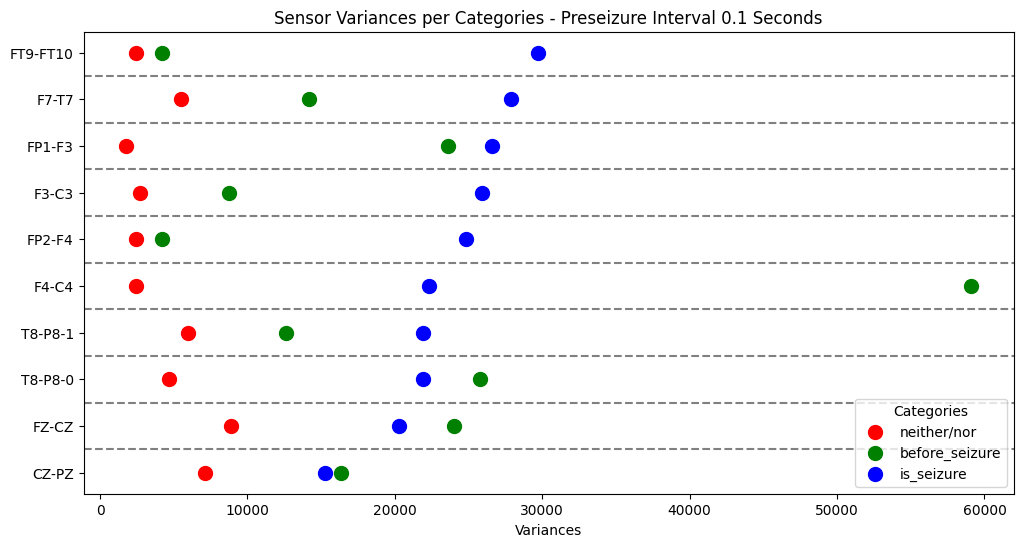

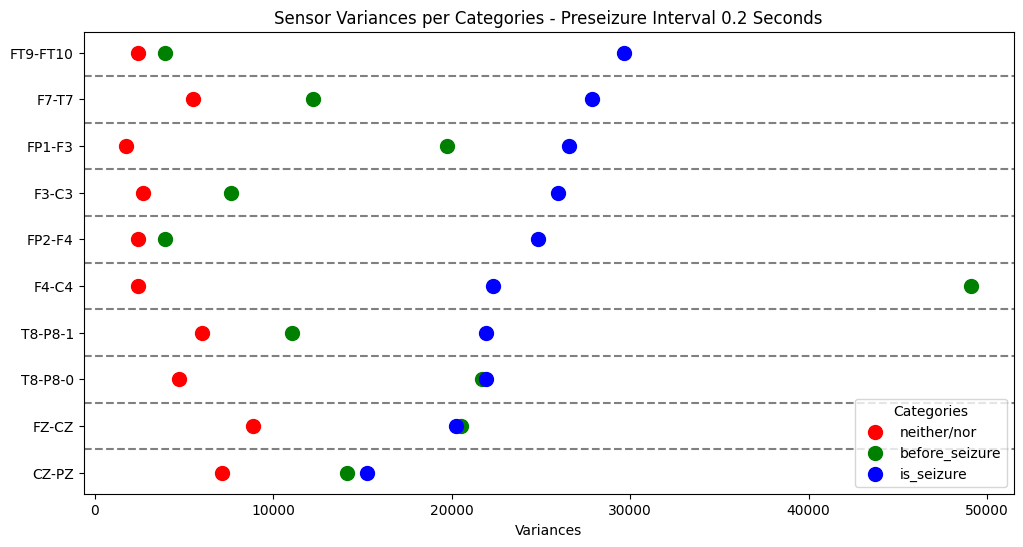

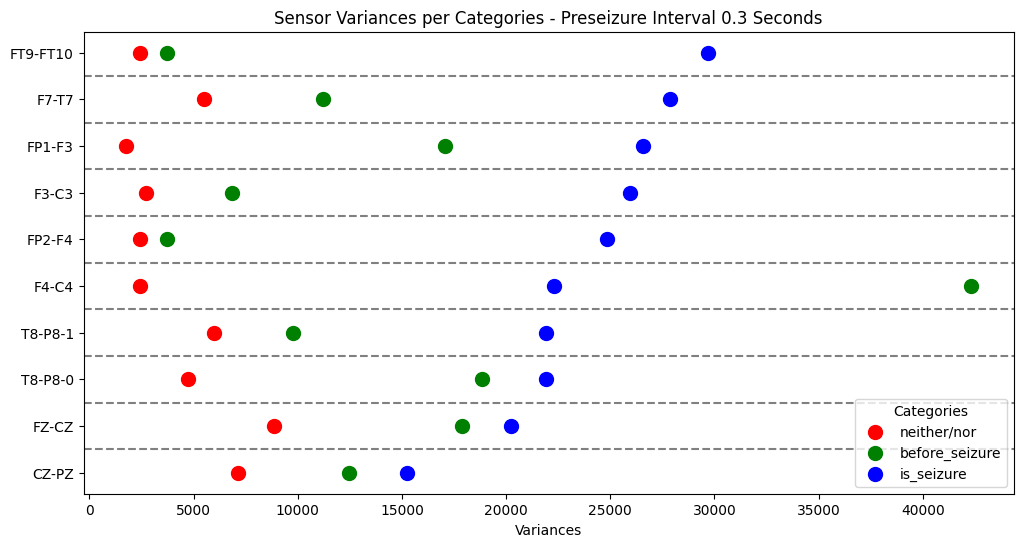

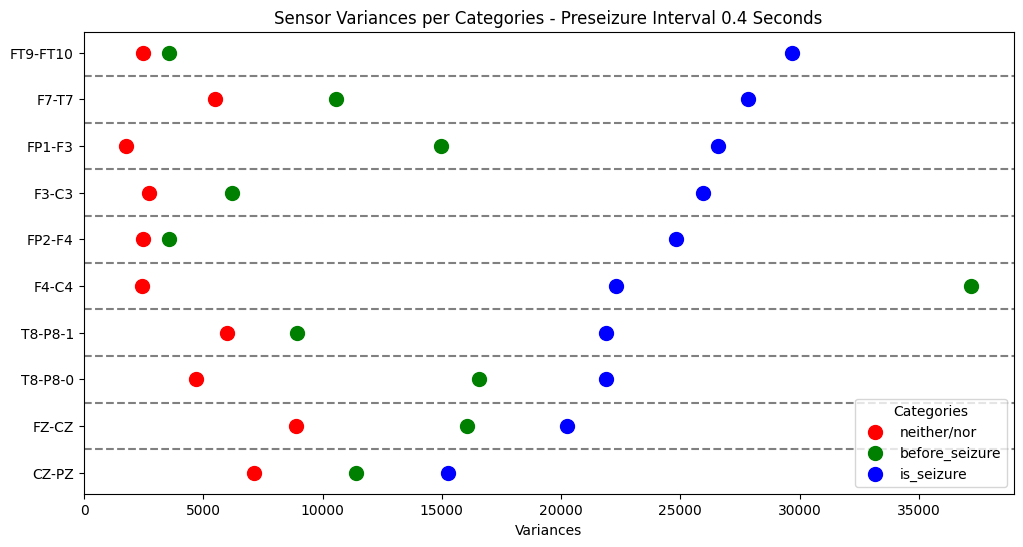

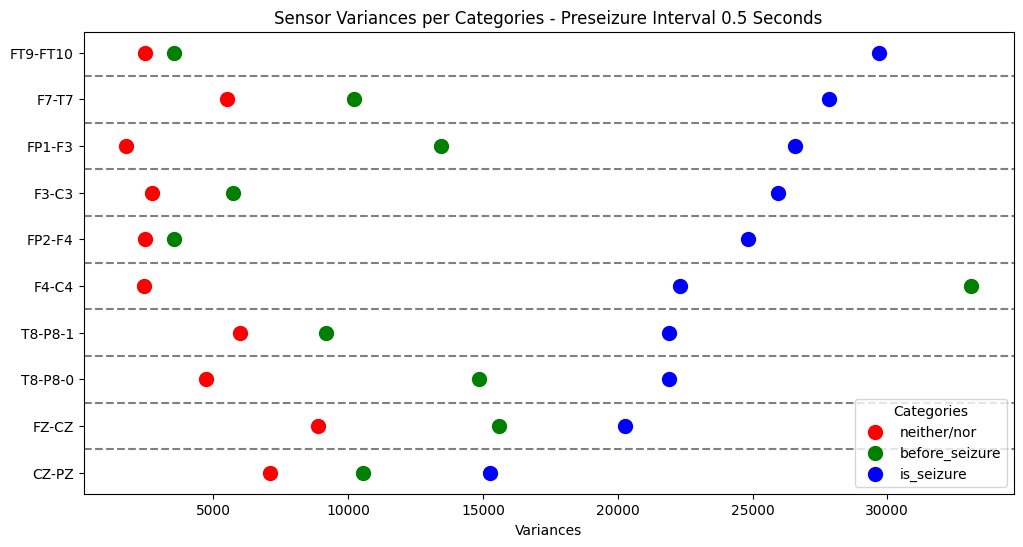

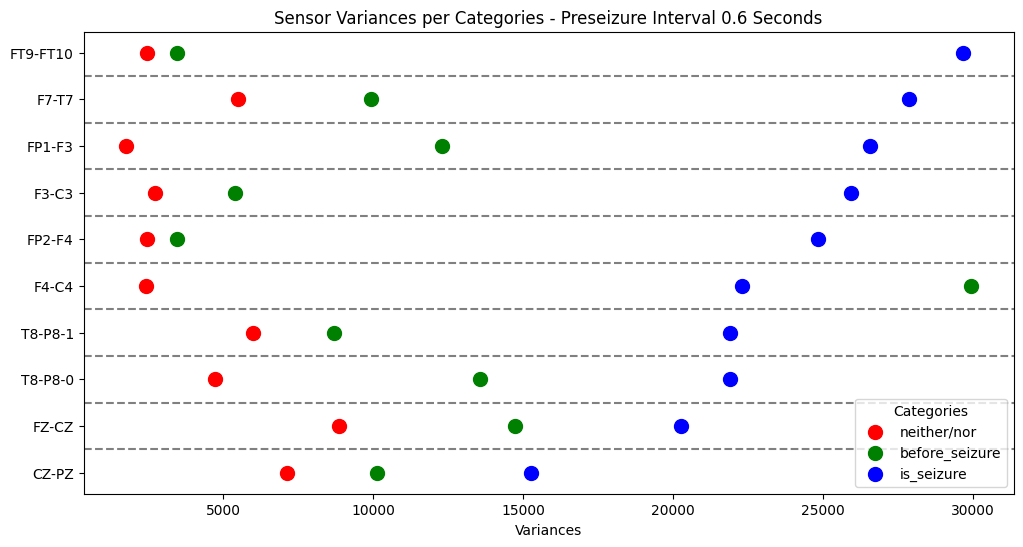

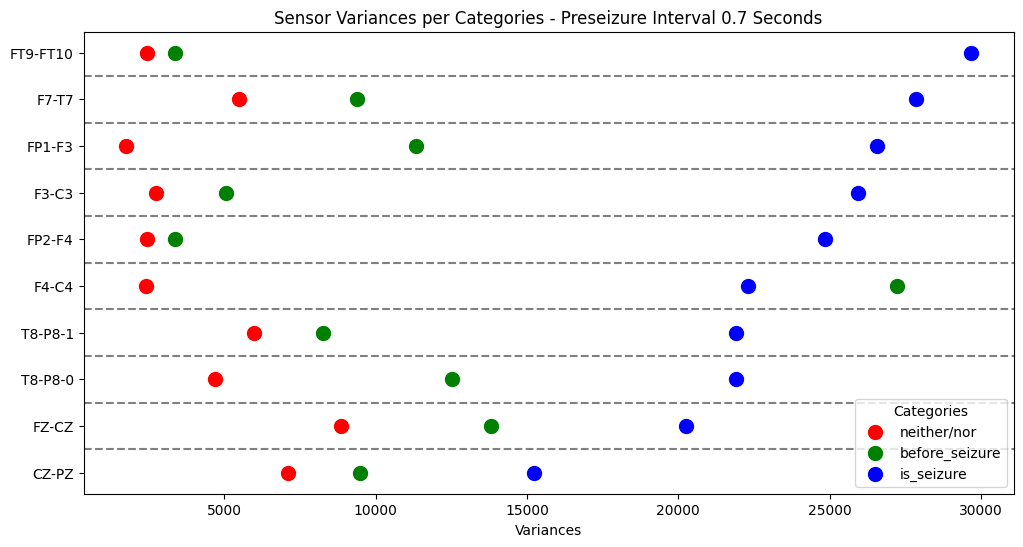

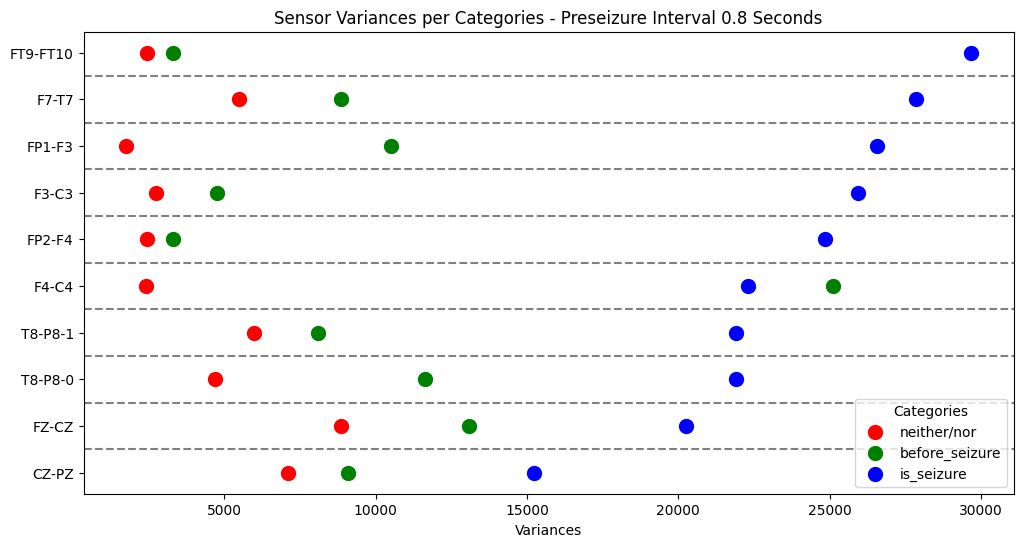

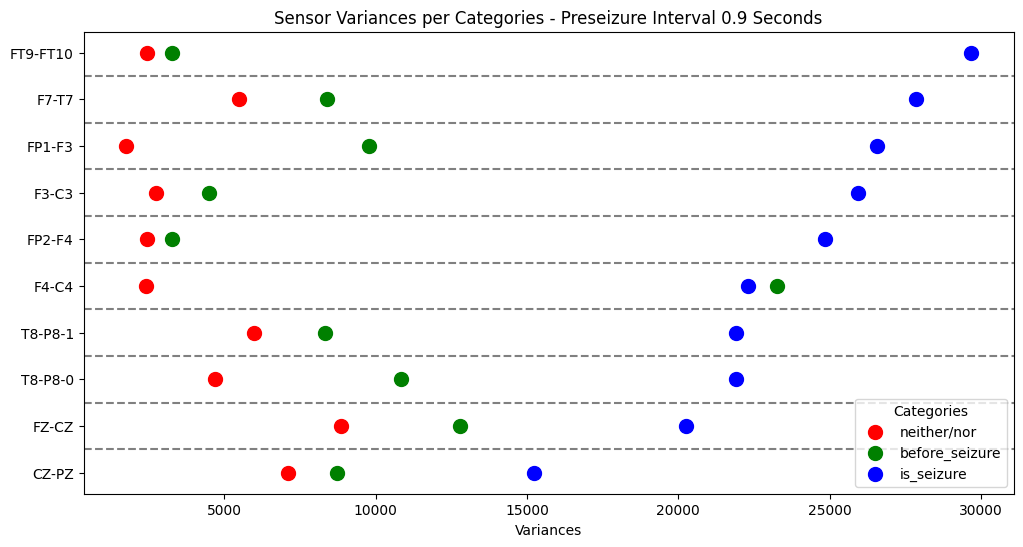

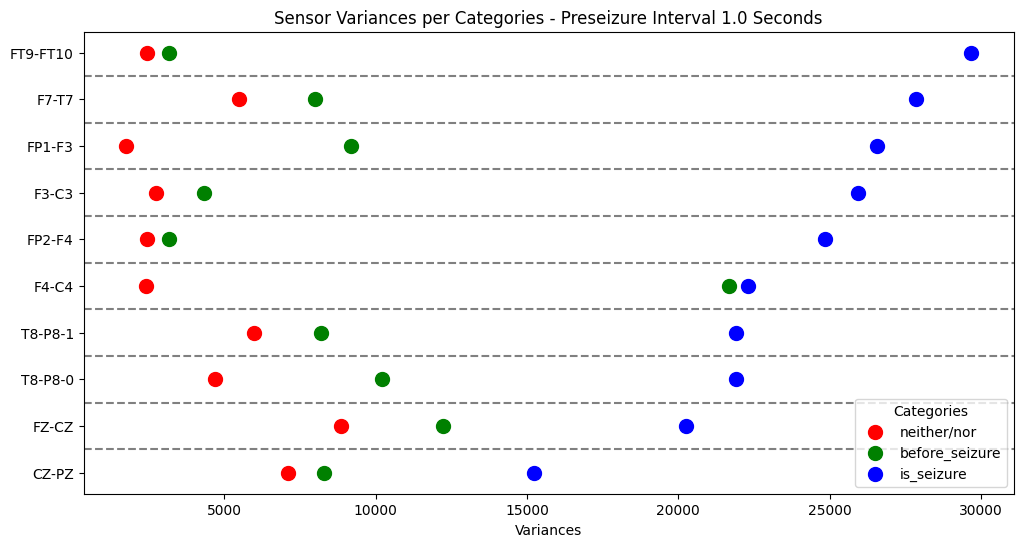

In [59]:
# Define the order of categories in the legend
category_order = ['neither/nor', 'before_seizure', 'is_seizure']

# Get unique values of preseizure_interval
preseizure_intervals = result_df['preseizure_interval'].unique()

# Iterate over each preseizure_interval and create a subplot
for interval in preseizure_intervals:
    # Filter data for the current preseizure_interval
    subset = result_df[result_df['preseizure_interval'] == interval]

    # Sort the y-values based on the x-values for 'is_seizure'
    is_seizure_subset = subset[subset['categories'] == 'is_seizure']
    is_seizure_subset = is_seizure_subset.sort_values(by='variances')

    # Create the point plot using Matplotlib
    fig, ax = plt.subplots(figsize=(12, 6))

    # Filter data by categories and plot points for each category without connecting them
    for category, color in zip(category_order, ['r', 'g', 'b']):
        if category == 'is_seizure':
            category_subset = is_seizure_subset  # Use sorted subset for 'is_seizure'
        else:
            category_subset = subset[subset['categories'] == category]
        y_values = range(len(category_subset['sensors']))  # Custom y-values to separate sensors
        ax.scatter(category_subset['variances'], y_values, label=category, c=color, marker='o', s=100)

    # Customize the plot
    ax.set_yticks(range(len(category_subset['sensors'])))
    ax.set_yticklabels(category_subset['sensors'])
    plt.xlabel('Variances')
    plt.title(f'Sensor Variances per Categories - Preseizure Interval {interval} Seconds')
    plt.legend(title='Categories', loc='lower right')

    # Add horizontal grid lines between y-values (sensors)
    for y in range(1, len(category_subset['sensors'])):
        ax.axhline(y - 0.5, color='gray', linestyle='--')

    plt.show()


In [60]:
# Pivot the DataFrame
transposed_df = result_df.pivot(index=['preseizure_interval', 'sensors'],
                                columns='categories',
                                values='variances').reset_index()

# Rename the columns for clarity
transposed_df.columns.name = None  # Remove the columns' name


In [61]:
transposed_df["difference_pre_before"] = abs(transposed_df["neither/nor"] - transposed_df["before_seizure"])
transposed_df["difference_pre_seizure"] = transposed_df["neither/nor"] - transposed_df["is_seizure"]

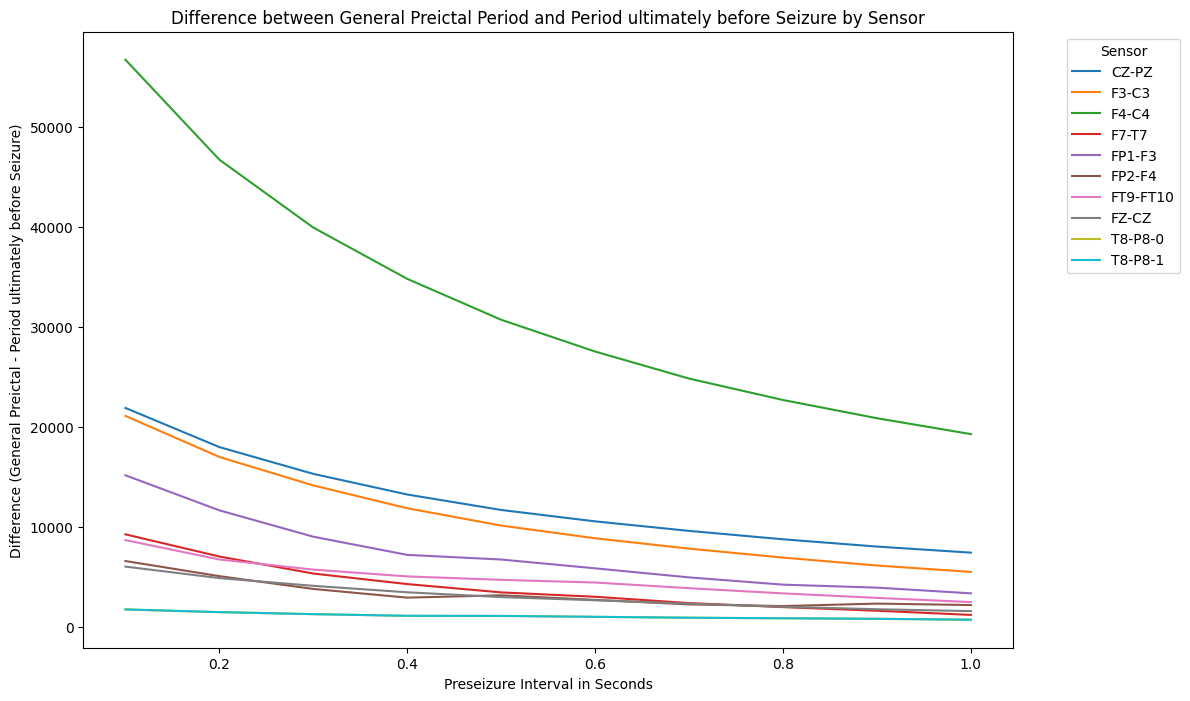

In [63]:
fig, ax = plt.subplots(figsize=(12, 8))

# Iterate over unique sensors and plot a line for each
for sensor in transposed_df['sensors'].unique():
    sensor_data = transposed_df[transposed_df['sensors'] == sensor]
    ax.plot(sensor_data['preseizure_interval'], sensor_data['difference_pre_before'], label=sensor)

# Customize the plot
ax.set_xlabel('Preseizure Interval in Seconds')
ax.set_ylabel('Difference (General Preictal - Period ultimately before Seizure)')
ax.set_title('Difference between General Preictal Period and Period ultimately before Seizure by Sensor')
ax.legend(title='Sensor', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

In [64]:
import os
import pandas as pd
import numpy as np

def get_seizure_sequence(source_path="data"):
    file_names = []
    number_of_seizures = []
    seizure_start = []
    seizure_end = []

    for folder_name in os.listdir(source_path):
        if not folder_name.startswith("."):
            folder_path = os.path.join(source_path, folder_name)
                
            if os.path.isdir(folder_path):
                for file_name in os.listdir(folder_path):
                    if file_name.endswith(".txt"):
                        file_path = os.path.join(folder_path, file_name)

                with open(file_path) as f:
                    for line in f:
                        line = line.strip()

                        if "File" in line and "Name" in line:
                            file_names.append(line.split(": ", 1)[1])

                        if "Number" in line and "Seizure" in line:
                            number_of_seizures.append(int(line.split(": ", 1)[1]))

                        if "Seizure" in line and "Start" in line:
                            seizure_start.append(float(line.split(": ", 1)[1].split()[0]))

                        if "Seizure" in line and "End" in line:
                            seizure_end.append(float(line.split(": ", 1)[1].split()[0]))

    # # Check if any .txt files were found
    # if not file_names:
    #     print("No .txt files found in the specified directory.")
    #     return None

    data = {
        "file_name": file_names,
        "number_of_seizures": number_of_seizures
    }

    df_seizure = pd.DataFrame(data)
    df_seizures_tmp = df_seizure.loc[df_seizure.index.repeat(df_seizure['number_of_seizures'])]
    df_no_seizures_tmp = df_seizure[df_seizure["number_of_seizures"] == 0]

    df = pd.concat([df_seizures_tmp, df_no_seizures_tmp], ignore_index=True)
    df["seizure_start"] = np.where(df["number_of_seizures"] == 0, np.nan, seizure_start * (len(df) // len(seizure_start)) + seizure_start[:len(df) % len(seizure_start)])
    df["seizure_end"] = np.where(df["number_of_seizures"] == 0, np.nan, seizure_end * (len(df) // len(seizure_end)) + seizure_end[:len(df) % len(seizure_end)])

    return df

In [65]:
df = get_seizure_sequence("data")

In [66]:
def extract_left_digits(input_string):
    split_string = input_string.split('_')
    left_digits = int(''.join(filter(str.isdigit, split_string[0])))
    return left_digits

In [67]:
df["patient_id"] = df['file_name'].apply(extract_left_digits)

In [68]:
df_filtered = df[df['patient_id'].isin(DEFAULT_PATIENTS)].copy()

In [69]:
df_filtered.loc[:, "seizure_length"] = df_filtered["seizure_end"] - df_filtered["seizure_start"]

In [70]:
df_filtered = df_filtered.dropna()

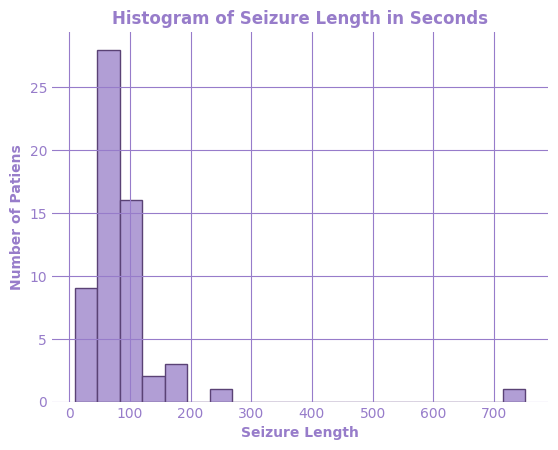

In [72]:
# Setting up the color scheme
hist_color = '#b19ed5'
text_color = '#977cca'
hist_edge_color = "#5a4275"
background_color = 'none'  # Setting background color to transparent

# Creating the histogram with customized colors
plt.hist(df_filtered["seizure_length"], bins=20, edgecolor=hist_edge_color, color=hist_color)
plt.xlabel('Seizure Length', color=text_color, weight='bold')  # Making x-label bold
plt.ylabel('Number of Patiens', color=text_color, weight='bold')  # Making y-label bold
plt.title('Histogram of Seizure Length in Seconds', color=text_color, weight='bold')  # Making title bold
plt.grid(True, color=text_color)
plt.gca().set_facecolor(background_color)

# Removing axis lines and ticks while keeping tick labels and grid
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.tick_params(axis='both', which='both', length=0)  # Hides ticks

# Set tick label colors
plt.gca().tick_params(axis='x', colors=text_color)
plt.gca().tick_params(axis='y', colors=text_color)

# Save the plot with a transparent background
plt.savefig('histogram_transparent_bg.png', transparent=True)
plt.show()


In [73]:
x = df_filtered.groupby("patient_id")["number_of_seizures"].count().reset_index()

In [74]:
# Counting the number of patients per number of seizures
seizure_count = x['number_of_seizures'].value_counts().reset_index()
#seizure_count.columns = ['number_of_seizures', 'count_of_patients']

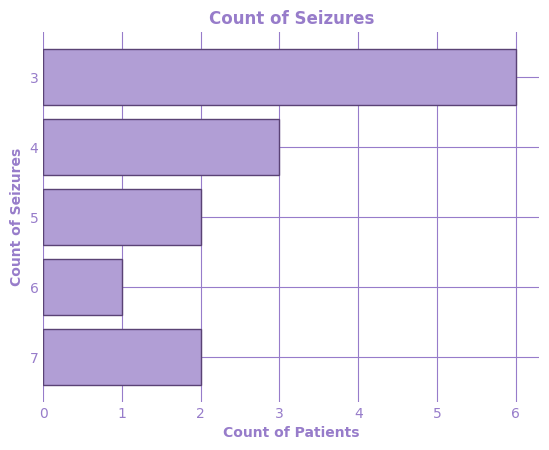

In [76]:
# Sort the DataFrame by 'count' in descending order
seizure_count_sorted = seizure_count.sort_values(by='number_of_seizures', ascending=True)

# Setting up the colors
# Setting up the colors
bar_color = '#b19ed5'
bar_edge_color = '#5a4275'
background_color = "none"
#text_color = '#5a4275'
text_color = '#977cca'

# Creating the plot
plt.figure()

# Plot gridlines first
plt.grid(axis='both', linestyle='-', color=text_color)

# Plot bars on top of the gridlines
bars = plt.barh(seizure_count_sorted['number_of_seizures'], seizure_count_sorted['count'], color=bar_color, edgecolor=bar_edge_color)
plt.xlabel('Count of Patients', color=text_color, weight="bold")
plt.ylabel('Count of Seizures', color=text_color, weight="bold")
plt.title('Count of Seizures', color=text_color, weight="bold")
plt.gca().invert_yaxis()  # Invert y-axis to sort by count descendingly
plt.tick_params(axis='x', colors=text_color)
plt.tick_params(axis='y', colors=text_color)

# Adjusting zorder of bars to be on top of gridlines
for bar in bars:
    bar.set_zorder(2)

# Hide axis spines and ticks
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.tick_params(axis='both', which='both', length=0)

# Save the plot with a transparent background
plt.savefig('barplot_transparent_bg.png', transparent=True)
plt.show()

In [109]:
# Select the patient, session and channels
raw = data_import.return_pandas_df(patient="chb04", session="chb04_05.edf", channels=["F4-C4"])

chb04_05.edf was import but not resampled 256Hz.
chb04_05.edf seizure and buffer was labeled


In [110]:
# Convert it to a dataframe 
df = raw[0]

In [111]:
# Recalculate the timedelta index into seconds and store it in a list
numeric = df.index.total_seconds()

In [112]:
numeric.max()

9535.99609375

In [113]:
# Add the seconds of recording to the dataframe
df["seconds"] = numeric

In [ ]:
# You don't need this code. It was only to generate the figure if there is exactly one seizure per file

# # Filter the DataFrame for rows where 'is_seizure' is True
# seizure_data = df[df['is_seizure']]

# # Get the minimum and maximum values of 'seconds' when 'is_seizure' is True
# seizure_start = seizure_data['seconds'].min()
# seizure_end = seizure_data['seconds'].max()

In [ ]:
time = []
prediction = []
signal = []

tmp = {"time": time,
       "prediction": prediction,
       "signal": signal}

df = pd.DataFrame(tmp)

In [102]:
# Here we create a new df which counts the number of seizures and when they started and ended (in seconds)

# Initializing variables
seizure_number = 0
start_seizure = None
end_seizure = None

seizure_intervals = []

# Iterating through the DataFrame to identify seizure intervals
for index, row in df.iterrows():
    if row['is_seizure']:
        if start_seizure is None:
            start_seizure = row['seconds']
            seizure_number += 1
    else:
        if start_seizure is not None:
            end_seizure = row['seconds']
            seizure_intervals.append((seizure_number, start_seizure, end_seizure))
            start_seizure = None
            end_seizure = None

# Creating a DataFrame with seizure intervals
seizure_df = pd.DataFrame(seizure_intervals, columns=['seizure_number', 'start_seizure', 'end_seizure'])

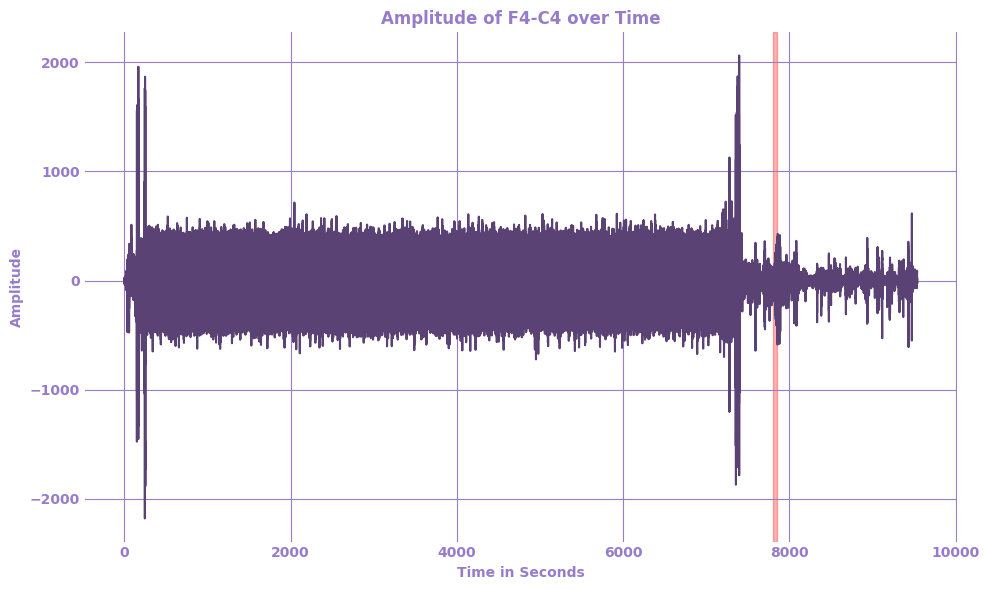

In [47]:
# This is the code for each figure

# Select the sensor
# We could generalize to loop through all channels
sensor_name = "F4-C4"

# Custom color values
amplitude_color = '#5a4275'
background_color = "none"
grid_color = '#977cca'
axvspan_color = 'red'

# Plot the selected sensor's EEG data
plt.figure(figsize=(10, 6))
plt.plot(df["seconds"], df[sensor_name], color=amplitude_color)  # Change amplitude color
plt.title(f'Amplitude of {sensor_name} over Time', color=grid_color, fontweight='bold')
plt.xlabel('Time in Seconds', color=grid_color, fontweight='bold')
plt.ylabel('Amplitude', color=grid_color, fontweight='bold')
plt.grid(True, color=grid_color)  # Set grid color
plt.gca().set_facecolor(background_color)  # Set background color to transparent

# Iterate through the seizure df to plot a shade of red on the amplitude for each seizure sequence
for index, row in seizure_df.iterrows():
    seizure_start = row['start_seizure']
    seizure_end = row['end_seizure']
    plt.axvspan(seizure_start, seizure_end, color=axvspan_color, alpha=0.3, label=f'Seizure {row["seizure_number"]}')

# Change font properties for tick labels and set their color
plt.xticks(fontweight='bold', color=grid_color)
plt.yticks(fontweight='bold', color=grid_color)

# Remove frame around the plot
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.tick_params(axis='both', which='both', length=0)

plt.tight_layout()
plt.savefig('amplitude_transparent_bg.png', transparent=True)
plt.show()

In [32]:
df.head()

channel,F4-C4,is_seizure,before_seizure,seconds
0 days 00:00:00,5.665446,False,False,0.000000
0 days 00:00:00.003906250,0.195360,False,False,0.003906
0 days 00:00:00.007812500,0.195360,False,False,0.007812
0 days 00:00:00.011718750,0.195360,False,False,0.011719
0 days 00:00:00.015625,0.586081,False,False,0.015625


In [22]:
# This is for the zoomed in part.

# Change the limits of the secods according to the area you want to zoom into
df_filtered = df[(df["seconds"] >= 2980) & (df["seconds"] <= 3040)]
seizure_df_filtered = seizure_df[(seizure_df["start_seizure"] >= 2980) & (seizure_df["end_seizure"] <= 3040)]

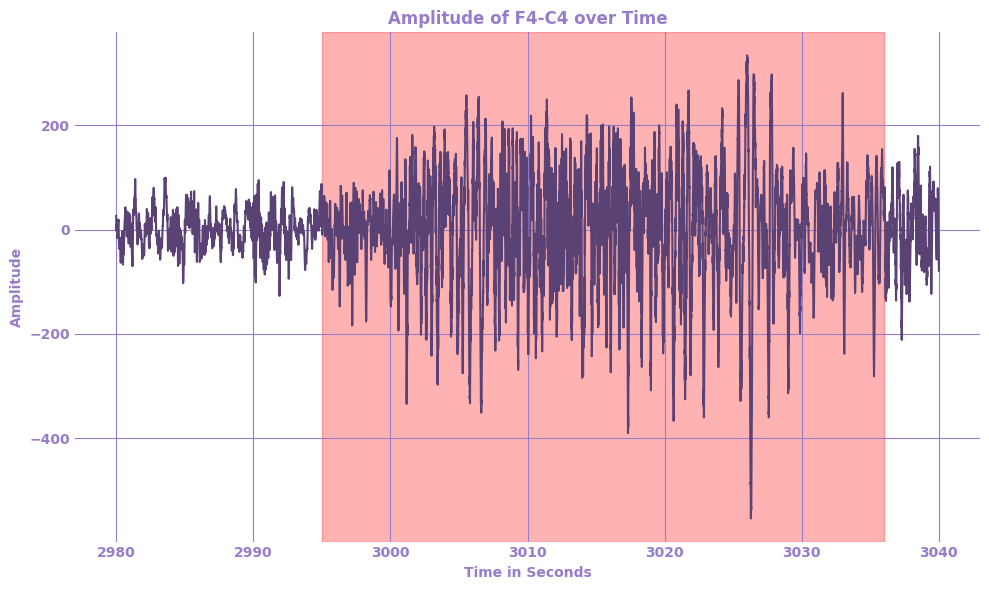

In [23]:
# This is the code for each figure

# Select the sensor
# We could generalize to loop through all channels
sensor_name = "F4-C4"

# Custom color values
amplitude_color = '#5a4275'
background_color = "none"
grid_color = '#977cca'
axvspan_color = 'red'

# Plot the selected sensor's EEG data
plt.figure(figsize=(10, 6))
plt.plot(df_filtered["seconds"], df_filtered[sensor_name], color=amplitude_color)  # Change amplitude color
plt.title(f'Amplitude of {sensor_name} over Time', color=grid_color, fontweight='bold')
plt.xlabel('Time in Seconds', color=grid_color, fontweight='bold')
plt.ylabel('Amplitude', color=grid_color, fontweight='bold')
plt.grid(True, color=grid_color)  # Set grid color
plt.gca().set_facecolor(background_color)  # Set background color to transparent

# Iterate through the seizure df to plot a shade of red on the amplitude for each seizure sequence
for index, row in seizure_df_filtered.iterrows():
    seizure_start = row['start_seizure']
    seizure_end = row['end_seizure']
    plt.axvspan(seizure_start, seizure_end, color=axvspan_color, alpha=0.3, label=f'Seizure {row["seizure_number"]}')

# Change font properties for tick labels and set their color
plt.xticks(fontweight='bold', color=grid_color)
plt.yticks(fontweight='bold', color=grid_color)

# Remove frame around the plot
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.tick_params(axis='both', which='both', length=0)

plt.tight_layout()
plt.savefig('amplitude_transparent_bg.png', transparent=True)
plt.show()